In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.models import googlenet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [10]:
# Define GoogLeNet Model for MNIST
class CustomGoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomGoogLeNet, self).__init__()
        # Load pre-trained GoogLeNet
        self.model = googlenet(weights=torchvision.models.GoogLeNet_Weights.DEFAULT)
        # Modify the first convolutional layer to accept 1 input channel (grayscale)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the final fully connected layer to output the required number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        # Disable input transformation (transform_input)
        self.model.transform_input = False
        # Disable auxiliary classifiers
        self.model.aux1 = None
        self.model.aux2 = None

    def forward(self, x):
        return self.model(x)


# Data Transformations and MNIST Dataset
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize MNIST images to a smaller size for faster computation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


MNIST

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-7-7c6b9dac5c6f>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-7-7c6b9dac5c6f>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Training Loss: 0.0777
Test Accuracy: 98.78%
Epoch 2/10
Training Loss: 0.0356
Test Accuracy: 99.04%
Epoch 3/10
Training Loss: 0.0262
Test Accuracy: 99.43%
Epoch 4/10
Training Loss: 0.0219
Test Accuracy: 99.30%
Epoch 5/10
Training Loss: 0.0199
Test Accuracy: 99.50%
Epoch 6/10
Training Loss: 0.0069
Test Accuracy: 99.70%
Epoch 7/10
Training Loss: 0.0041
Test Accuracy: 99.73%
Epoch 8/10
Training Loss: 0.0033
Test Accuracy: 99.73%
Epoch 9/10
Training Loss: 0.0026
Test Accuracy: 99.71%
Epoch 10/10
Training Loss: 0.0023
Test Accuracy: 99.72%

Final Metrics for MNIST using GoogLeNet:
Accuracy: 99.72%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


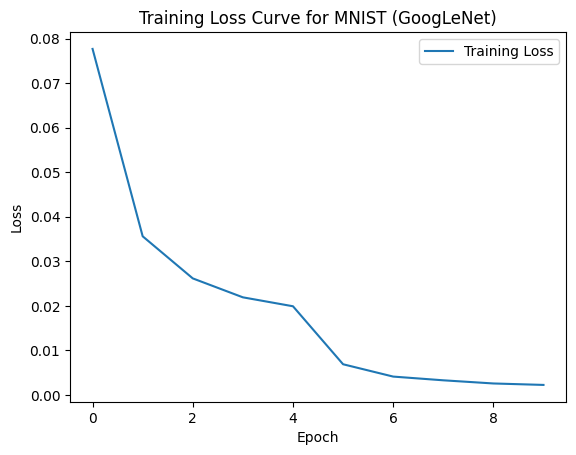

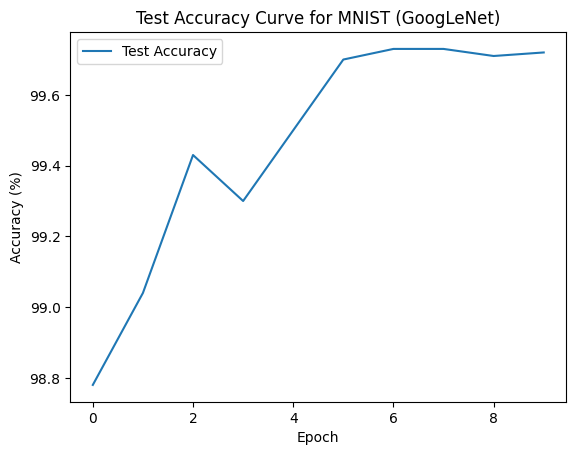

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = CustomGoogLeNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Update Learning Rate
    scheduler.step()

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for MNIST using GoogLeNet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for MNIST (GoogLeNet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for MNIST (GoogLeNet)')
plt.legend()
plt.show()

FMNIST

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/10


<ipython-input-8-9a07f5f22a0b>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-8-9a07f5f22a0b>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Training Loss: 0.3298
Test Accuracy: 90.00%
Epoch 2/10
Training Loss: 0.2207
Test Accuracy: 91.58%
Epoch 3/10
Training Loss: 0.1877
Test Accuracy: 92.59%
Epoch 4/10
Training Loss: 0.1640
Test Accuracy: 93.27%
Epoch 5/10
Training Loss: 0.1440
Test Accuracy: 92.43%
Epoch 6/10
Training Loss: 0.0860
Test Accuracy: 94.56%
Epoch 7/10
Training Loss: 0.0624
Test Accuracy: 94.79%
Epoch 8/10
Training Loss: 0.0475
Test Accuracy: 94.67%
Epoch 9/10
Training Loss: 0.0340
Test Accuracy: 94.56%
Epoch 10/10
Training Loss: 0.0225
Test Accuracy: 94.34%

Final Metrics for FMNIST using GoogLeNet:
Accuracy: 94.34%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


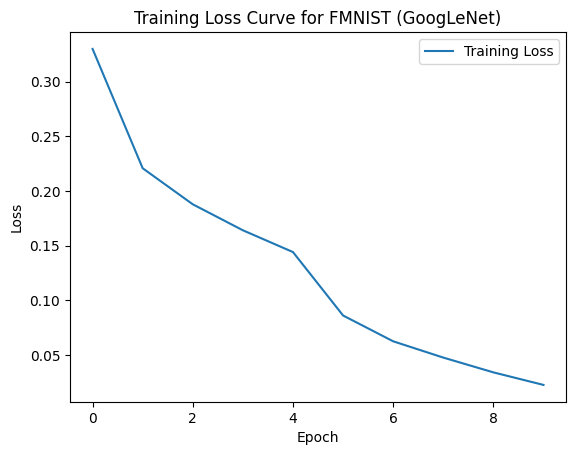

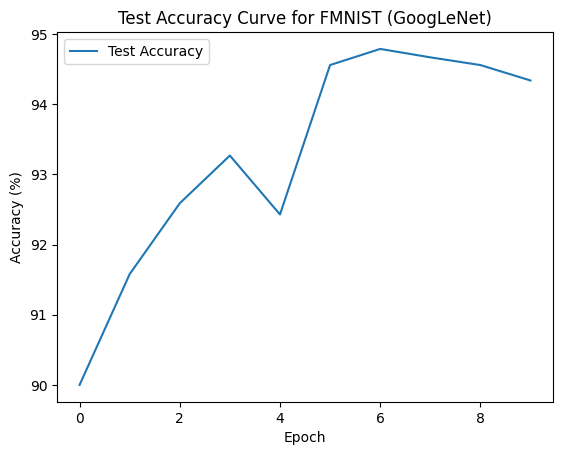

In [8]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = CustomGoogLeNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Update Learning Rate
    scheduler.step()

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for FMNIST using GoogLeNet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for FMNIST (GoogLeNet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for FMNIST (GoogLeNet)')
plt.legend()
plt.show()

CIFAR-10

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Training Loss: 0.4598
Test Accuracy: 87.83%
Epoch 2/10
Training Loss: 0.2850
Test Accuracy: 89.84%
Epoch 3/10
Training Loss: 0.2298
Test Accuracy: 89.79%
Epoch 4/10
Training Loss: 0.1988
Test Accuracy: 90.16%
Epoch 5/10
Training Loss: 0.1683
Test Accuracy: 90.17%
Epoch 6/10
Training Loss: 0.0825
Test Accuracy: 94.64%
Epoch 7/10
Training Loss: 0.0506
Test Accuracy: 94.99%
Epoch 8/10
Training Loss: 0.0379
Test Accuracy: 95.30%
Epoch 9/10
Training Loss: 0.0296
Test Accuracy: 95.11%
Epoch 10/10
Training Loss: 0.0239
Test Accuracy: 95.18%

Final Metrics for CIFAR-10 using GoogLeNet:
Accuracy: 95.18%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


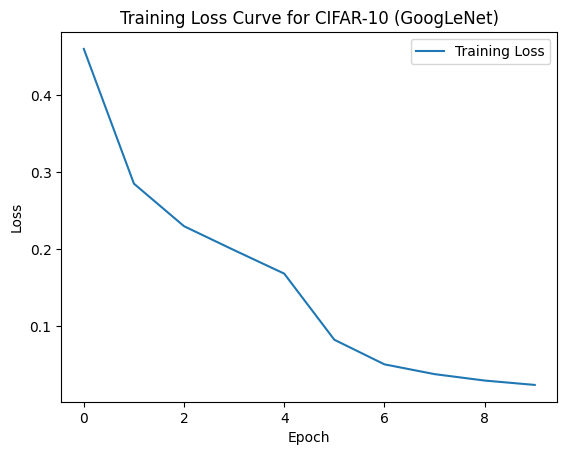

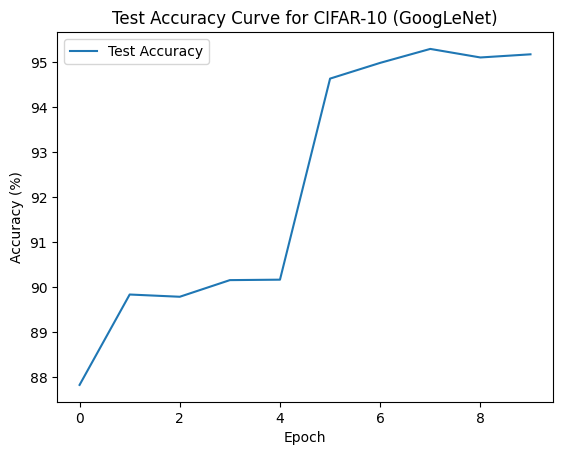

In [14]:
class CustomGoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomGoogLeNet, self).__init__()
        # Load pre-trained GoogLeNet
        self.model = googlenet(weights=torchvision.models.GoogLeNet_Weights.DEFAULT)
        # Modify the final fully connected layer to output the required number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        # Disable auxiliary classifiers if not needed
        self.model.aux1 = None
        self.model.aux2 = None

    def forward(self, x):
        return self.model(x)

# Data Transformations and CIFAR-10 Dataset
transform_train = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize CIFAR-10 images for GoogLeNet
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(112, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3-channel images
])

transform_test = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = CustomGoogLeNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Mixed Precision Training
scaler = torch.amp.GradScaler()

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Update Learning Rate
    scheduler.step()

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for CIFAR-10 using GoogLeNet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for CIFAR-10 (GoogLeNet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for CIFAR-10 (GoogLeNet)')
plt.legend()
plt.show()
